# S669 dataset 
The notebook contain a preprocessing of the dataset: https://academic.oup.com/bib/article/23/2/bbab555/6502552 

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm   
import seaborn as sns
import matplotlib.pyplot as plt

/home/shaharax/.conda/envs/esm2_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = '../data/S669/'
df_path = folder_path + 'Data_s669_with_predictions.csv'
df = pd.read_csv(df_path)
df.head()

,Unnamed: 0,Protein,PDB_Mut,Mut_seq,TEMP,pH,DDG_checked_dir,DOI,nmr_xray,resolution,...,SEC_STR_dir,SEC_STR_inv,ThermoNet_dir,ThermoNet_inv,ACDC-NN-Seq_inv,ACDC-NN_inv,PDB_wild,DDGun_inv,DDG_checked_inv,DDGun3D_inv
0,0,1A0FA,S11A,S11A,329.83,6.5,-1.80,10.1042/BJ20061707,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.10 ANGSTROMS.,...,T,T,0.0209,-0.1772,-0.041723,-0.319539,1A0F,-0.0,1.80,-0.5
1,1,1A7VA,A104H,A104H,298.15,6.5,-2.69,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,H,0.1795,-0.0441,0.495499,0.308649,1A7V,0.5,2.69,0.1
2,2,1A7VA,A66H,A66H,298.15,6.5,-1.98,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,C,C,0.0017,-0.2933,-0.114885,-0.392607,1A7V,-0.8,1.98,-0.5
3,3,1A7VA,A91H,A91H,298.15,6.5,-1.70,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,H,0.2384,-0.0203,0.264991,0.183003,1A7V,0.2,1.70,0.1
4,4,1A7VA,D3H,D3H,298.15,6.5,-1.36,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,C,H,0.0510,-0.1593,0.000000,0.126173,1A7V,-0.5,1.36,-0.2


In [4]:
df['chain'] = df['Protein'].apply(lambda x: x[-1])
df['check'] = df[['Protein','PDB_wild']].apply(lambda x: x['Protein'][:-1] == x['PDB_wild'], axis=1)
df['check'].value_counts()

True    669
Name: check, dtype: int64

In [5]:
# Get list of proteins
protein_names = df['PDB_wild'].unique()
print(protein_names[:5])
print(protein_names.shape)   


['1A0F' '1A7V' '1BA3' '1BFM' '1BNL']
(94,)


In [6]:
# Add wilde type row for each unique protein
df_wild = pd.DataFrame(columns=['Protein', 'PDB_wild', 'chain'])
for protein in protein_names:
    df_wild = df_wild.append({'Protein': protein + '0', 'PDB_wild': protein, 'chain': '0'}, ignore_index=True)
df_wild.head()

,Protein,PDB_wild,chain
0,1A0F0,1A0F,0
1,1A7V0,1A7V,0
2,1BA30,1BA3,0
3,1BFM0,1BFM,0
4,1BNL0,1BNL,0


Get proteins pdbs

In [20]:
import os
import requests

# Directory to save PDB files
output_dir = folder_path + 'pdb_files'
os.makedirs(output_dir, exist_ok=True)

# List of PDB IDs
pdb_ids = protein_names

# Base URL for PDB files (RCSB PDB)
base_url = "https://files.rcsb.org/download/{}.pdb"

for pdb_id in pdb_ids:
    break
    url = base_url.format(pdb_id)
    response = requests.get(url)
    if response.status_code == 200:
        file_path = os.path.join(output_dir, f"{pdb_id}.pdb")
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded PDB for {pdb_id}")
    else:
        print(f"Failed to download PDB for {pdb_id}, status code: {response.status_code}")


## Helper functions to get coords and sequence

In [7]:
NANO_TO_ANGSTROM = 0.1

# Define the list of atom types to save
atom_types = ['N', 'CA', 'C']
atom_mapper = {'N': 'CoordN', 'C': 'CoordC', 'CA': 'CoordAlpha', 'CB': 'CoordBeta'}
MISSING_COORD = torch.tensor([0, 0, 0])
OTHER_ACID = '-'

In [8]:
def add_cb(crd_coords):
        """
        Add the Cbeta atom to the coordinates
        Args:
            crd_coords (tensor): tensor of shape [n_residues,3,3]

        Returns:
            crd_coords: tensor shape [n_residues,4,3]
        """
        # Get the coordinates of the backbone atoms
        N, CA, C = crd_coords[:, 0], crd_coords[:, 1], crd_coords[:, 2]
        # CB = CA + c1*(N-CA) + c2*(C-CA) + c3* (N-CA)x(C-CA)
        CAmN = N - CA
        # CAmN = CAmN / torch.sqrt(CAmN ** 2).sum(dim=2, keepdim=True)
        CAmC = C - CA
        # CAmC = CAmC / torch.sqrt(CAmC ** 2).sum(dim=2, keepdim=True)
        ANxAC = torch.cross(CAmN, CAmC, dim=1)

        A = torch.cat((CAmN.reshape(-1, 1), CAmC.reshape(-1, 1), ANxAC.reshape(-1, 1)), dim=1)
        c = torch.tensor([0.5507, 0.5354, -0.5691]) / 100  # torch.tensor([1.1930, 1.2106, -2.7906]) #
        b = (A @ c).reshape(-1,3)
        CB = CA - b
      
        # Add Cbeta coordinates to existing coordinates array
        crd_coords = torch.cat((crd_coords, CB.unsqueeze(1)), dim=1)
        return crd_coords

In [9]:
from Bio import PDB

def get_chain_sequence(pdb_file, chain_id):
    # Create a PDB parser
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)

    # Extract the specified chain
    chain = structure[0][chain_id]

    # Get the sequence of the chain
    sequence = ""
    for residue in chain:
        if PDB.is_aa(residue):
            sequence += PDB.Polypeptide.three_to_one(residue.get_resname())

    return sequence

# Example usage
pdb_file = folder_path + 'pdb_files/1A0F.pdb'
chain_id = 'A'  # Replace with the chain ID you want
sequence = get_chain_sequence(pdb_file, chain_id)
print(len(sequence))

201


In [24]:
dict_seq = {0:'A', 1:'C', 2:'D', 3:'E', 4:'F', 5:'G', 6:'H', 7:'I', 8:'K', 9:'L', 10:'M', 11:'N', 12:'P', 13:'Q', 14:'R', 15:'S', 16:'T', 17:'V', 18:'W', 19:'Y'}
dict_to_seq = ''.join([v for k, v in dict_seq.items()])
dict_to_seq

'ACDEFGHIKLMNPQRSTVWY'

In [10]:
# get sequence from PDB file
import Bio.PDB
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import seq1

def get_sequence(pdb_file):
    parser = PDBParser()
    structure = parser.get_structure('X', pdb_file)
    ppb = Bio.PDB.PPBuilder()
    sequence = ''
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())
    return sequence

def get_coords(pdb_file_path, protein_name, chains):
    pdb_parser = PDBParser(QUIET=True)
    structure = pdb_parser.get_structure(protein_name, pdb_file_path)
    out_data = dict(dict())
    sequence_dict = dict()
    sequence = {}
    for model in structure:
        for chain in model:
            if chain.id not in chains:
                continue
            for residue in chain:
                residue_id = residue.id[1] - 1
                atom_data_dict = {atom_type: [] for atom_type in atom_types}
                if 'CA' in residue:
                    if PDB.is_aa(residue):
                        sequence[residue_id] = seq1(residue.resname)
                    else:
                        continue
                    for atom in residue:
                        # Check if the atom type is in the list of atom types to save
                        if atom.get_name() in atom_types:
                            # Get the coordinates of the atom
                            coord = atom.get_coord()
                            # Add the coordinates to the corresponding atom type list in the data dictionary
                            atom_data_dict[atom.get_name()] = torch.from_numpy(coord)
                    if 'C' not in residue:
                        atom_data_dict['C'] = MISSING_COORD
                    if 'N' not in residue:
                        atom_data_dict['N'] = MISSING_COORD
                    # if 'CB' not in residue and residue.get_resname() == 'GLY':
                    #     try:
                    #         atom_data_dict['CB'] = torch.from_numpy(residue['2HA'].get_coord())
                    #     except KeyError:
                    #         atom_data_dict['CB'] = torch.from_numpy(residue['HA2'].get_coord())
                        # atom_data_dict['CB'] = MISSING_COORD
                    # store the atoms foreach residue id, id is stored for mask later
                    sequence_dict[residue_id] = atom_data_dict
                    
    # Convert the dictionary of sequences to a string
    sequence = ''.join([''.join([v for k, v in sequence.items()])])
    
    return torch.stack([torch.stack(list(v.values())) for v in sequence_dict.values()]), sequence

# test for one protein
protein_name = '1GUA'
idx = df[df['PDB_wild'] == protein_name].index[0]
output_dir = folder_path + 'pdb_files'
pdb_file_path = output_dir + '/' + protein_name + '.pdb'
coords, seq = get_coords(pdb_file_path, protein_name, [df['chain'][idx]])
# add CB
coords = add_cb(coords)
# Add nano to angstrom conversion
coords = coords * NANO_TO_ANGSTROM
print(coords.shape)

# test sequence
# sequence = get_chain_sequence(pdb_file_path,df['chain'][idx])
sequence = seq
print(sequence)
print(len(sequence))


torch.Size([76, 4, 3])
NTIRVFLPNKQRTVVNVRNGMSLHDCLMKALKVRGLQPECCAVFRLLHEHKGKKARLDWNTDAASLIGEELQVDFL
76


In [1]:
import re
# Convert three-letter amino acid codes to one-letter codes
aa_dict = {
        'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
        'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
        'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
        'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
    }

def extract_pdb_info(pdb_file, atom_types=['N', 'CA', 'C'], chain_id='A'):
    coordinates = {}
    sequence = {}
    
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                splited_line = line.split()
                atom_id = splited_line[1]
                atom_type = splited_line[2]
                residue_type = splited_line[3]
                chain_line_id = splited_line[4]
                if chain_line_id not in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N','1', '2', '3', '4', '5', '6', '7', '8', '9']:
                    # print(splited_line)
                    chain_line_id = splited_line[4][0]
                    residue_id = splited_line[4][1:]
                    x = float(splited_line[5])
                    y = float(splited_line[6])
                    z = float(splited_line[7])
                else:
                    residue_id = splited_line[5]
                    x = float(splited_line[6])
                    y = float(splited_line[7])
                    z = float(splited_line[8])
                
                if chain_line_id != chain_id:
                    continue
                # Extract coordinates
                if atom_type not in atom_types:
                    continue
                
                if residue_id not in coordinates.keys():
                    coordinates[residue_id] = {}
                    for atom in atom_types:
                        coordinates[residue_id][atom] = [0.0, 0.0, 0.0]
                
                coordinates[residue_id][atom_type] = [x, y, z]
                
                # Extract amino acid for sequence
                if residue_type not in aa_dict.keys():
                    sequence[residue_id] = 'X' 
                else:
                    sequence [residue_id] = aa_dict[residue_type]
    
    sequence_str = ''.join([''.join([v for k, v in sequence.items()])])
    coordinates = torch.stack([torch.stack([torch.tensor(v) for v in list(v.values())]) for v in coordinates.values()])
        
    return coordinates, sequence_str, sequence

# Usage
pdb_file = output_dir + '/1GUA.pdb'
coords, seq, seq_dict = extract_pdb_info(pdb_file,chain_id='0')

print(seq)
print(seq_dict)
print(len(seq))
print(coords.shape)

NameError: name 'output_dir' is not defined

In [27]:
df.head()

,Unnamed: 0,Protein,PDB_Mut,Mut_seq,TEMP,pH,DDG_checked_dir,DOI,nmr_xray,resolution,...,ThermoNet_dir,ThermoNet_inv,ACDC-NN-Seq_inv,ACDC-NN_inv,PDB_wild,DDGun_inv,DDG_checked_inv,DDGun3D_inv,chain,check
0,0,1A0FA,S11A,S11A,329.83,6.5,-1.80,10.1042/BJ20061707,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.10 ANGSTROMS.,...,0.0209,-0.1772,-0.041723,-0.319539,1A0F,-0.0,1.80,-0.5,A,True
1,1,1A7VA,A104H,A104H,298.15,6.5,-2.69,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,0.1795,-0.0441,0.495499,0.308649,1A7V,0.5,2.69,0.1,A,True
2,2,1A7VA,A66H,A66H,298.15,6.5,-1.98,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,0.0017,-0.2933,-0.114885,-0.392607,1A7V,-0.8,1.98,-0.5,A,True
3,3,1A7VA,A91H,A91H,298.15,6.5,-1.70,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,0.2384,-0.0203,0.264991,0.183003,1A7V,0.2,1.70,0.1,A,True
4,4,1A7VA,D3H,D3H,298.15,6.5,-1.36,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,0.0510,-0.1593,0.000000,0.126173,1A7V,-0.5,1.36,-0.2,A,True


In [28]:
# After going through the data, we see that some proteins have multiple chains. protein 4N6V0 first chain is currupted in the pdb use the 2 chain
# df[df['PDB_wild'] == '4N6V']['Protein'] = '4N6V2'
df.loc[df['PDB_wild'] == '4N6V', 'Protein'] = '4N6V2'
df.loc[df['PDB_wild'] == '4N6V', 'chain'] = '2'

In [29]:
protein_names = df['PDB_wild']
chains = df['chain']
PDB_Mut = df['PDB_Mut']
PDB_Mut[:5]

0     S11A
1    A104H
2     A66H
3     A91H
4      D3H
Name: PDB_Mut, dtype: object

In [30]:
# Create one tensor for all proteins
all_coords = []
all_sequences = []
all_masks = []
all_ids = []
all_mutations = []
all_mutations_seq = []
faulty_proteins = []

for i, protein_name in enumerate(tqdm(protein_names)):
    pdb_file_path = output_dir + '/' + protein_name + '.pdb'
    coords, sequence, seq_dict =extract_pdb_info(pdb_file_path, chain_id= chains[i])
    coords = torch.tensor(coords)
    # add CB
    coords = add_cb(coords)
    # Add nano to angstrom conversion
    coords = coords * NANO_TO_ANGSTROM
    all_coords.append(coords)
    
    mask_tensor = (coords != 0).all(dim=2).all(dim=1).float()
    all_masks.append(mask_tensor)
    
    # mutation
    mutation = PDB_Mut[i]
    if mutation[1:-1] not in seq_dict.keys():
        print(seq_dict)
        print('Mutation not found in sequence')
        print('Protein:', protein_name)
        print('Mutation:', mutation)
        print('Mutation index:', mutation[1:-1])
        faulty_proteins.append(i)
        continue 
    seq_dict[mutation[1:-1]] = mutation[-1]
    mutation_seq = ''.join([v for k, v in seq_dict.items()])
    all_mutations_seq.append(mutation_seq)
    
    if len(sequence) != len(mutation_seq):
        print('Sequence length does not match the number of residues')
        print('Protein:', protein_name)
        print('Sequence length:', len(sequence))
        print('Number of residues:', len(mutation_seq))
        faulty_proteins.append(i)
    
    if len(sequence) != coords.shape[0]:
        print('Sequence length does not match the number of residues')
        print('Protein:', protein_name)
        print('Sequence length:', len(sequence))
        print('Number of residues:', coords.shape[0])
        faulty_proteins.append(i)
    all_sequences.append(sequence)
    
    all_ids.append(protein_name)
    all_mutations.append(PDB_Mut[i])

# save the data
torch.save(all_coords, folder_path + 'all_coords.pt')
torch.save(all_sequences, folder_path + 'all_sequences.pt')
torch.save(all_masks, folder_path + 'all_masks.pt')
torch.save(all_ids, folder_path + 'all_ids.pt')
torch.save(all_mutations, folder_path + 'all_mutations.pt')
torch.save(all_mutations_seq, folder_path + 'all_mutations_seq.pt')
print('Data saved')

  0%|          | 0/669 [00:00<?, ?it/s]

/home/shaharax/.conda/envs/esm2_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
100%|██████████| 669/669 [00:09<00:00, 69.24it/s] 


Data saved


In [31]:
len(all_coords), len(all_sequences), len(all_masks), len(all_ids), len(all_mutations)

(669, 669, 669, 669, 669)

In [32]:
df.iloc[faulty_proteins]

,Unnamed: 0,Protein,PDB_Mut,Mut_seq,TEMP,pH,DDG_checked_dir,DOI,nmr_xray,resolution,...,ThermoNet_dir,ThermoNet_inv,ACDC-NN-Seq_inv,ACDC-NN_inv,PDB_wild,DDGun_inv,DDG_checked_inv,DDGun3D_inv,chain,check


## Get proT5 embedding 

In [33]:
#@title Import dependencies. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50) 
# import requests
from transformers import T5Tokenizer, T5EncoderModel
import torch
import re
import os
from tqdm import tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

#@title Load encoder-part of ProtT5 in half-precision. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50 in half-precision) 
transformer_link = "Rostlab/prot_t5_xl_half_uniref50-enc"
print("Loading: {}".format(transformer_link))
model = T5EncoderModel.from_pretrained(transformer_link)
model.full() if device=='cpu' else model.half() # only cast to full-precision if no GPU is available
model = model.to(device)
model = model.eval()
tokenizer = T5Tokenizer.from_pretrained(transformer_link, do_lower_case=False )

sequence_examples = ["PRTEINO", "GPSGLGLPAGLYAFNSGGISLDLGINDPVPFNTVGSQFGTAISQLDADTFVISETGFYKITVIANTATASVLGGLTIQVNGVPVPGTGSSLISLGAPIVIQAITQITTTPSLVEVIVTGLGLSLALGTSASIIIEKVA"]
def get_emb(sequence_examples):
    seq_len = len(sequence_examples[0])
    # this will replace all rare/ambiguous amino acids by X and introduce white-space between all amino acids
    sequence_examples = [" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in sequence_examples]

    # tokenize sequences and pad up to the longest sequence in the batch
    ids = tokenizer.batch_encode_plus(sequence_examples, add_special_tokens=True, padding="longest")
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    # generate embeddings
    with torch.no_grad():
        embedding_repr = model(input_ids=input_ids,attention_mask=attention_mask)

    # extract embeddings for the first ([0,:]) sequence in the batch while removing padded & special tokens ([0,:7]) 
    emb_0 = embedding_repr.last_hidden_state[0,:seq_len]
    return emb_0

proT5_emb = get_emb([all_sequences[0]]).to('cpu')
proT5_emb.shape

Using device: cuda:0
Loading: Rostlab/prot_t5_xl_half_uniref50-enc


torch.Size([201, 1024])

In [34]:
all_proT5_embs = []
all_wild_proT5_embs = []
for seq in tqdm(all_mutations_seq):
    # get emb
    emb = get_emb([seq])
    all_proT5_embs.append(emb)

for seq in tqdm(all_sequences):
    # get emb
    emb = get_emb([seq])
    all_wild_proT5_embs.append(emb)

torch.save(all_wild_proT5_embs, folder_path + 'all_proT5_wild_embs.pt')    
torch.save(all_proT5_embs, folder_path + 'all_proT5_mut_embs.pt')

100%|██████████| 669/669 [00:12<00:00, 51.98it/s]


In [35]:
# check inconsistency
for i in range(len(all_sequences)):
    if len(all_sequences[i]) != all_coords[i].shape[0]:
        print(i, all_sequences[i], all_coords[i].shape[0])

## Get one hot

In [36]:
import sys
sys.path.append('../')
from train_utils import get_one_hot
# Get one-hot encoding
all_one_hot = []
all_wildtype_one_hot = []
for i, sequence in enumerate(tqdm(all_mutations_seq)):
    one_hot = get_one_hot(sequence)
    all_one_hot.append(one_hot)

for i, sequence in enumerate(tqdm(all_sequences)):
    one_hot = get_one_hot(sequence)
    all_wildtype_one_hot.append(one_hot)

torch.save(all_wildtype_one_hot, folder_path + 'all_wildtype_one_hot.pt')
torch.save(all_one_hot, folder_path + 'all_one_hot.pt')

100%|██████████| 669/669 [00:00<00:00, 2098.06it/s]


In [37]:
# check inconsistency
for i in range(len(all_one_hot)):
    if all_one_hot[i].shape[0] != all_coords[i].shape[0]:
        print(i, all_sequences[i], all_coords[i].shape[0])

In [38]:
# save All data in one tensor
all_data = {"all_coords": all_coords, "all_sequences": all_sequences, "all_masks": all_masks, "all_ids": all_ids, "all_mutations": all_mutations, "all_mutations_seq": all_mutations_seq, "all_proT5_embs": all_proT5_embs, "all_one_hot": all_one_hot, "all_wildtype_one_hot": all_wildtype_one_hot, "all_wild_proT5_embs": all_wild_proT5_embs}
torch.save(all_data, folder_path + 'all_data.pt')

In [39]:
all_ids[0]

'1A0F'

# Inference results after model running

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## base model

In [2]:
folder_path = '../data/S669/'
df_path = folder_path + 'Data_s669_with_predictions.csv'
df = pd.read_csv(df_path)
df.head()

,Unnamed: 0,Protein,PDB_Mut,Mut_seq,TEMP,pH,DDG_checked_dir,DOI,nmr_xray,resolution,...,SEC_STR_dir,SEC_STR_inv,ThermoNet_dir,ThermoNet_inv,ACDC-NN-Seq_inv,ACDC-NN_inv,PDB_wild,DDGun_inv,DDG_checked_inv,DDGun3D_inv
0,0,1A0FA,S11A,S11A,329.83,6.5,-1.80,10.1042/BJ20061707,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.10 ANGSTROMS.,...,T,T,0.0209,-0.1772,-0.041723,-0.319539,1A0F,-0.0,1.80,-0.5
1,1,1A7VA,A104H,A104H,298.15,6.5,-2.69,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,H,0.1795,-0.0441,0.495499,0.308649,1A7V,0.5,2.69,0.1
2,2,1A7VA,A66H,A66H,298.15,6.5,-1.98,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,C,C,0.0017,-0.2933,-0.114885,-0.392607,1A7V,-0.8,1.98,-0.5
3,3,1A7VA,A91H,A91H,298.15,6.5,-1.70,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,H,0.2384,-0.0203,0.264991,0.183003,1A7V,0.2,1.70,0.1
4,4,1A7VA,D3H,D3H,298.15,6.5,-1.36,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,C,H,0.0510,-0.1593,0.000000,0.126173,1A7V,-0.5,1.36,-0.2


In [3]:
# df_deepEF = pd.read_csv('../data/S669/inference_results.csv')
df_deepEF = pd.read_csv('../data/S669/res/trianed_models-cycle_per/inference_results.csv')
df_deepEF.head()

,Unnamed: 0,index,id,mut,mut_folded_energy,mut_unfolded_energy,mut_delta_G,wt_folded_energy,wt_unfolded_energy,wt_delta_G,ddG
0,0,0.0,1A0F,S11A,-20.088078,0.458690,20.546766,-21.389109,0.244182,21.633291,-1.086525
1,1,1.0,1A7V,A104H,-19.825708,-0.281896,19.543812,-20.199415,-0.320912,19.878504,-0.334692
2,2,2.0,1A7V,A66H,-20.382591,-0.536984,19.845608,-20.056248,-0.589444,19.466803,0.378805
3,3,3.0,1A7V,A91H,-20.516598,-0.478218,20.038380,-19.519505,-0.528765,18.990740,1.047640
4,4,4.0,1A7V,D3H,-18.763433,-0.372619,18.390816,-20.426575,-0.640016,19.786558,-1.395742


In [4]:
df_deepEF[df_deepEF['id'] == '1BA3']

,Unnamed: 0,index,id,mut,mut_folded_energy,mut_unfolded_energy,mut_delta_G,wt_folded_energy,wt_unfolded_energy,wt_delta_G,ddG
14,14,14.0,1BA3,H461D,-16.823938,0.711833,17.535770,-19.344093,0.687645,20.031738,-2.495968
15,15,15.0,1BA3,H489D,-17.609901,0.326922,17.936823,-17.692852,0.340591,18.033443,-0.096621
16,16,16.0,1BA3,H489K,-18.414017,0.611773,19.025789,-17.338978,0.511905,17.850882,1.174908
17,17,17.0,1BA3,H489M,-17.623857,0.719933,18.343790,-18.672985,0.602530,19.275515,-0.931725


In [5]:
df.groupby('PDB_wild').count()
# get max count
a = df.groupby('PDB_wild').size()
a[a == a.max()]

PDB_wild
2PTL    68
dtype: int64

In [6]:
# Check ddG cooreltaion between deepEF and experimental data
df['deepEF'] = df_deepEF['ddG']
# Group by protein and get pearson correlation, remove nan values
protein_df = df.groupby('PDB_wild')[['DDG_checked_dir', 'deepEF']].corr(method='pearson').dropna()
protein_df

DDG_checked_dir    deepEF
PDB_wild                                           
1A7V     DDG_checked_dir         1.000000  0.136920
         deepEF                  0.136920  1.000000
1BA3     DDG_checked_dir         1.000000  0.760696
         deepEF                  0.760696  1.000000
1BFM     DDG_checked_dir         1.000000 -1.000000
...                                   ...       ...
4N6V     deepEF                 -0.992709  1.000000
4WAA     DDG_checked_dir         1.000000 -0.518547
         deepEF                 -0.518547  1.000000
5VP3     DDG_checked_dir         1.000000 -0.691752
         deepEF                 -0.691752  1.000000

[132 rows x 2 columns]

In [7]:
display(protein_df)

DDG_checked_dir    deepEF
PDB_wild                                           
1A7V     DDG_checked_dir         1.000000  0.136920
         deepEF                  0.136920  1.000000
1BA3     DDG_checked_dir         1.000000  0.760696
         deepEF                  0.760696  1.000000
1BFM     DDG_checked_dir         1.000000 -1.000000
...                                   ...       ...
4N6V     deepEF                 -0.992709  1.000000
4WAA     DDG_checked_dir         1.000000 -0.518547
         deepEF                 -0.518547  1.000000
5VP3     DDG_checked_dir         1.000000 -0.691752
         deepEF                 -0.691752  1.000000

[132 rows x 2 columns]

In [8]:
# save only 1 protein pre pdb_wild
protein_df = protein_df.iloc[0::2]
protein_df

,,DDG_checked_dir,deepEF
PDB_wild,,,
1A7V,DDG_checked_dir,1.0,0.136920
1BA3,DDG_checked_dir,1.0,0.760696
1BFM,DDG_checked_dir,1.0,-1.000000
1D5G,DDG_checked_dir,1.0,-1.000000
1DIV,DDG_checked_dir,1.0,-0.033120
...,...,...,...
4BUQ,DDG_checked_dir,1.0,1.000000
4HE7,DDG_checked_dir,1.0,0.476416
4N6V,DDG_checked_dir,1.0,-0.992709


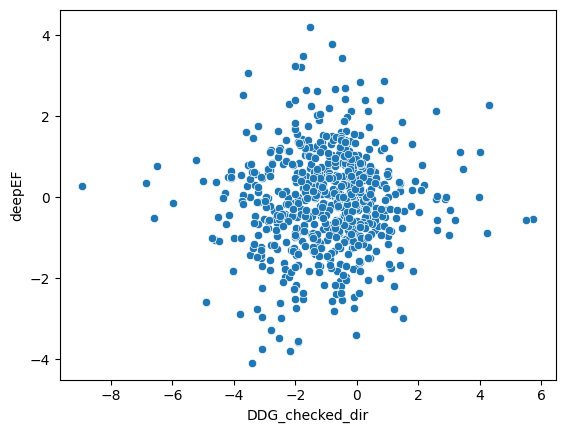

In [9]:
# plot diffrent cooreltion
sns.scatterplot(data=df, x='DDG_checked_dir', y='deepEF')
plt.show()

In [10]:
df[['DDG_checked_dir', 'deepEF']].corr(method='pearson')

,DDG_checked_dir,deepEF
DDG_checked_dir,1.00000,0.06056
deepEF,0.06056,1.00000


In [11]:
summery_df = pd.DataFrame(columns = ['Metric', 'Value'])
summery_df = summery_df.append({'Metric': 'Pearson Correlation', 'Value': df[['DDG_checked_dir', 'deepEF']].corr(method='pearson').iloc[0,1]}, ignore_index=True)
summery_df = summery_df.append({'Metric': 'MAE', 'Value': np.abs(df['DDG_checked_dir'] - df['deepEF']).mean()}, ignore_index=True)
summery_df = summery_df.append({'Metric': 'RMSE', 'Value': np.sqrt(((df['DDG_checked_dir'] - df['deepEF'])**2).mean())}, ignore_index=True)
summery_df

,Metric,Value
0,Pearson Correlation,0.060560
1,MAE,1.655150
2,RMSE,2.145856


In [12]:
df_megascale_protein = pd.read_csv('../data/megascale_proteins.csv')
df_megascale_protein.head()

,protein_name
0,1B7I
1,1A0N
2,1A32
3,1AOY
4,1BOD


In [13]:
protein_in_both = df[df['PDB_wild'].isin(df_megascale_protein['protein_name'])]['PDB_wild'].unique()
protein_in_both

array(['1O6X', '2HBB', '2PTL', '2WQG'], dtype=object)

In [14]:
mega_res_path = '../data/Processed_K50_dG_datasets/mutation_outputs/49'
for protein in protein_in_both:
    df_mega = pd.read_csv(mega_res_path + '/' + protein + '.csv')
    print(protein)
    print(df[df['PDB_wild'] == protein][['DDG_checked_dir', 'deepEF']])

1O6X
     DDG_checked_dir    deepEF
243            -1.20  0.510416
244            -1.40  0.632145
245             0.36 -0.150541
246            -0.30 -1.055405
247            -1.42 -0.885185
248            -1.88  0.859272
249            -0.98 -0.732149
250            -0.61  0.154863
251            -0.43  0.927523
252             0.42  0.460533
253            -1.31  1.259539
254            -1.31 -1.044001
255            -1.98 -0.952070
256            -0.97  0.077606
257            -0.08  0.034523
258            -0.49  0.857426
259            -1.10  0.507769
260            -1.08  0.157454
261            -1.10 -0.130604
262            -2.78 -1.184145
2HBB
     DDG_checked_dir    deepEF
320            -0.32 -0.166090
321            -1.79 -0.761511
322            -1.55  1.025913
323            -1.59  0.357420
324            -0.33 -0.528315
325            -0.55  1.170448
326            -0.22  1.389160
327            -0.03  0.955124
328            -0.79  1.412788
329            -1.30 -0.91098

## cycle with norm

In [16]:
folder_path = '../data/S669/'
df_path = folder_path + 'Data_s669_with_predictions.csv'
df = pd.read_csv(df_path)
df_deepEF = pd.read_csv('../data/S669/res/trianed_models-cycle_per_norm/inference_results.csv')
df_deepEF.head()

,Unnamed: 0,index,id,mut,mut_folded_energy,mut_unfolded_energy,mut_delta_G,wt_folded_energy,wt_unfolded_energy,wt_delta_G,ddG
0,0,0.0,1A0F,S11A,-22.459133,0.984383,23.443516,-22.338375,1.090545,23.428919,0.014597
1,1,1.0,1A7V,A104H,-19.902502,-1.084838,18.817663,-19.823002,-0.961367,18.861635,-0.043972
2,2,2.0,1A7V,A66H,-19.865395,-1.019162,18.846233,-19.823002,-0.961366,18.861635,-0.015402
3,3,3.0,1A7V,A91H,-19.819725,-1.129807,18.689919,-19.823002,-0.961366,18.861635,-0.171717
4,4,4.0,1A7V,D3H,-19.963940,-0.934367,19.029573,-19.823002,-0.961365,18.861637,0.167936


In [17]:
df['deepEF'] = df_deepEF['ddG']

In [18]:
summery_df = pd.DataFrame(columns = ['Metric', 'Value'])
summery_df = summery_df.append({'Metric': 'Pearson Correlation', 'Value': df[['DDG_checked_dir', 'deepEF']].corr(method='pearson').iloc[0,1]}, ignore_index=True)
summery_df = summery_df.append({'Metric': 'MAE', 'Value': np.abs(df['DDG_checked_dir'] - df['deepEF']).mean()}, ignore_index=True)
summery_df = summery_df.append({'Metric': 'RMSE', 'Value': np.sqrt(((df['DDG_checked_dir'] - df['deepEF'])**2).mean())}, ignore_index=True)
summery_df

,Metric,Value
0,Pearson Correlation,0.062195
1,MAE,1.456567
2,RMSE,1.916783


## Extra regularization

In [19]:
folder_path = '../data/S669/'
df_path = folder_path + 'Data_s669_with_predictions.csv'
df = pd.read_csv(df_path)
df_deepEF = pd.read_csv('../data/S669/res/trianed_models-cycle_per_norm_SM/inference_results.csv')
df_deepEF.head()

,Unnamed: 0,index,id,mut,mut_folded_energy,mut_unfolded_energy,mut_delta_G,wt_folded_energy,wt_unfolded_energy,wt_delta_G,ddG
0,0,0.0,1A0F,S11A,-2.484000,0.087388,2.571389,-2.471082,0.087837,2.558919,0.012470
1,1,1.0,1A7V,A104H,-2.184129,-0.113356,2.070773,-2.195401,-0.113832,2.081569,-0.010796
2,2,2.0,1A7V,A66H,-2.192743,-0.107547,2.085196,-2.195401,-0.113832,2.081569,0.003626
3,3,3.0,1A7V,A91H,-2.185019,-0.119603,2.065416,-2.195401,-0.113832,2.081569,-0.016153
4,4,4.0,1A7V,D3H,-2.215319,-0.114763,2.100557,-2.195401,-0.113832,2.081569,0.018987


In [22]:
df['deepEF_exp'] = (np.exp(-df_deepEF['mut_unfolded_energy']) - np.exp(-df_deepEF['mut_folded_energy'])) - (np.exp(-df_deepEF['wt_unfolded_energy']) - np.exp(-df_deepEF['wt_folded_energy']))

In [23]:
df['deepEF'] = df_deepEF['ddG']

In [24]:

summery_df = pd.DataFrame(columns = ['Metric', 'Value'])
summery_df = summery_df.append({'Metric': 'Pearson Correlation', 'Value': df[['DDG_checked_dir', 'deepEF_exp']].corr(method='pearson').iloc[0,1]}, ignore_index=True)
summery_df = summery_df.append({'Metric': 'MAE', 'Value': np.abs(df['DDG_checked_dir'] - df['deepEF_exp']).mean()}, ignore_index=True)
summery_df = summery_df.append({'Metric': 'RMSE', 'Value': np.sqrt(((df['DDG_checked_dir'] - df['deepEF_exp'])**2).mean())}, ignore_index=True)
summery_df

,Metric,Value
0,Pearson Correlation,-0.092069
1,MAE,1.531079
2,RMSE,2.037759


In [23]:
summery_df = pd.DataFrame(columns = ['Metric', 'Value'])
summery_df = summery_df.append({'Metric': 'Pearson Correlation', 'Value': df[['DDG_checked_dir', 'deepEF']].corr(method='pearson').iloc[0,1]}, ignore_index=True)
summery_df = summery_df.append({'Metric': 'MAE', 'Value': np.abs(df['DDG_checked_dir'] - df['deepEF']).mean()}, ignore_index=True)
summery_df = summery_df.append({'Metric': 'RMSE', 'Value': np.sqrt(((df['DDG_checked_dir'] - df['deepEF'])**2).mean())}, ignore_index=True)
summery_df

,Metric,Value
0,Pearson Correlation,0.088031
1,MAE,1.420985
2,RMSE,1.888226


## Cycle permutation

In [19]:
folder_path = '../data/S669/'
df_path = folder_path + 'Data_s669_with_predictions.csv'
df = pd.read_csv(df_path)
df.head()

,Unnamed: 0,Protein,PDB_Mut,Mut_seq,TEMP,pH,DDG_checked_dir,DOI,nmr_xray,resolution,...,SEC_STR_dir,SEC_STR_inv,ThermoNet_dir,ThermoNet_inv,ACDC-NN-Seq_inv,ACDC-NN_inv,PDB_wild,DDGun_inv,DDG_checked_inv,DDGun3D_inv
0,0,1A0FA,S11A,S11A,329.83,6.5,-1.80,10.1042/BJ20061707,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.10 ANGSTROMS.,...,T,T,0.0209,-0.1772,-0.041723,-0.319539,1A0F,-0.0,1.80,-0.5
1,1,1A7VA,A104H,A104H,298.15,6.5,-2.69,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,H,0.1795,-0.0441,0.495499,0.308649,1A7V,0.5,2.69,0.1
2,2,1A7VA,A66H,A66H,298.15,6.5,-1.98,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,C,C,0.0017,-0.2933,-0.114885,-0.392607,1A7V,-0.8,1.98,-0.5
3,3,1A7VA,A91H,A91H,298.15,6.5,-1.70,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,H,0.2384,-0.0203,0.264991,0.183003,1A7V,0.2,1.70,0.1
4,4,1A7VA,D3H,D3H,298.15,6.5,-1.36,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,C,H,0.0510,-0.1593,0.000000,0.126173,1A7V,-0.5,1.36,-0.2


In [20]:
# df_deepEF = pd.read_csv('../data/S669/inference_results.csv')
df_deepEF = pd.read_csv('../data/S669/res/trianed_models-cycle_per2/inference_results.csv')
df_deepEF.head()


,Unnamed: 0,index,id,mut,mut_folded_energy,mut_unfolded_energy,mut_delta_G,wt_folded_energy,wt_unfolded_energy,wt_delta_G,ddG
0,0,0.0,1A0F,S11A,-30.044321,-0.656260,29.388062,-29.901936,-0.630389,29.271547,0.116514
1,1,1.0,1A7V,A104H,-24.883881,-1.025242,23.858639,-24.733574,-0.991735,23.741838,0.116800
2,2,2.0,1A7V,A66H,-24.755383,-0.853918,23.901464,-24.733574,-0.991736,23.741838,0.159626
3,3,3.0,1A7V,A91H,-24.856852,-1.065225,23.791626,-24.733574,-0.991735,23.741838,0.049788
4,4,4.0,1A7V,D3H,-24.841545,-0.904760,23.936785,-24.733574,-0.991736,23.741838,0.194946


In [21]:
df['deepEF'] = df_deepEF['ddG']
df.head()

,Unnamed: 0,Protein,PDB_Mut,Mut_seq,TEMP,pH,DDG_checked_dir,DOI,nmr_xray,resolution,...,SEC_STR_inv,ThermoNet_dir,ThermoNet_inv,ACDC-NN-Seq_inv,ACDC-NN_inv,PDB_wild,DDGun_inv,DDG_checked_inv,DDGun3D_inv,deepEF
0,0,1A0FA,S11A,S11A,329.83,6.5,-1.80,10.1042/BJ20061707,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.10 ANGSTROMS.,...,T,0.0209,-0.1772,-0.041723,-0.319539,1A0F,-0.0,1.80,-0.5,0.116514
1,1,1A7VA,A104H,A104H,298.15,6.5,-2.69,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,0.1795,-0.0441,0.495499,0.308649,1A7V,0.5,2.69,0.1,0.116800
2,2,1A7VA,A66H,A66H,298.15,6.5,-1.98,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,C,0.0017,-0.2933,-0.114885,-0.392607,1A7V,-0.8,1.98,-0.5,0.159626
3,3,1A7VA,A91H,A91H,298.15,6.5,-1.70,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,0.2384,-0.0203,0.264991,0.183003,1A7V,0.2,1.70,0.1,0.049788
4,4,1A7VA,D3H,D3H,298.15,6.5,-1.36,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,0.0510,-0.1593,0.000000,0.126173,1A7V,-0.5,1.36,-0.2,0.194946


In [22]:
# Check cooreltaion
print(f"Pearson correlatoin: {df[['DDG_checked_dir', 'deepEF']].corr(method='pearson').iloc[0,1]}")
print(f"MAE: {np.abs(df['DDG_checked_dir'] - df['deepEF']).mean()}")
print(f"RMSE: {np.sqrt(((df['DDG_checked_dir'] - df['deepEF'])**2).mean())}")

Pearson correlatoin: 0.12926405609999947
MAE: 1.456130913259737
RMSE: 1.9214986259684352


In [23]:
# Get coorelation for each protein
df['deepEF'] = df_deepEF['ddG']
# Group by protein and get pearson correlation, remove nan values
protein_df = df.groupby('PDB_wild')[['DDG_checked_dir', 'deepEF']].corr(method='pearson').dropna()
# save only 1 protein pre pdb_wild
protein_df = protein_df.iloc[0::2]
protein_df

,,DDG_checked_dir,deepEF
PDB_wild,,,
1A7V,DDG_checked_dir,1.0,0.239626
1BA3,DDG_checked_dir,1.0,0.027473
1BFM,DDG_checked_dir,1.0,-1.000000
1D5G,DDG_checked_dir,1.0,-1.000000
1DIV,DDG_checked_dir,1.0,-0.115124
...,...,...,...
4BUQ,DDG_checked_dir,1.0,1.000000
4HE7,DDG_checked_dir,1.0,0.808513
4N6V,DDG_checked_dir,1.0,-0.590453


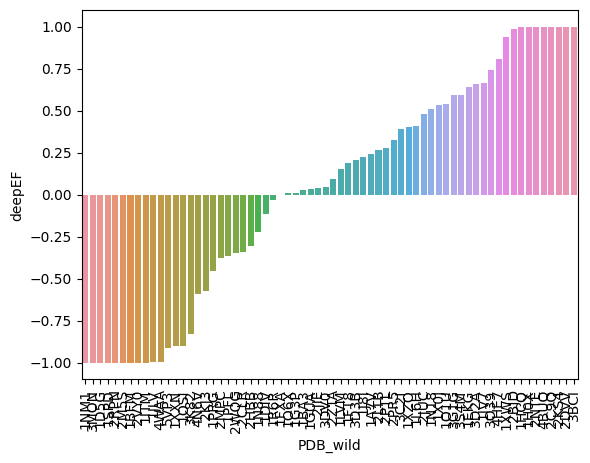

In [24]:
# sort and plot
protein_df = protein_df.sort_values('deepEF')
protein_df = protein_df.reset_index()
# protein_df['deepEF'] = protein_df['deepEF'].apply(lambda x: x[1])
sns.barplot(data=protein_df, x='PDB_wild', y='deepEF')
plt.xticks(rotation=90)
plt.show()

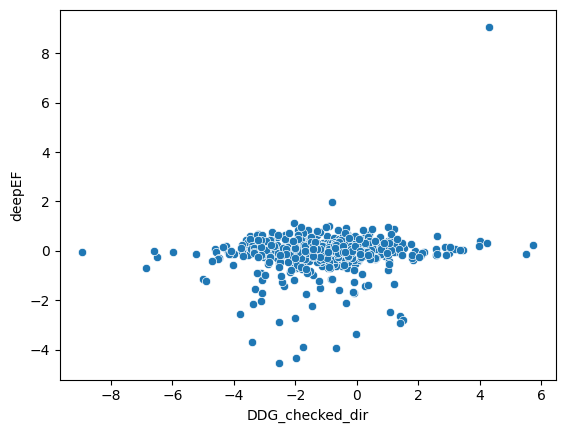

In [25]:
sns.scatterplot(data=df, x='DDG_checked_dir', y='deepEF')
plt.show()

In [27]:
print(f"Pearson correlatoin: {df[['DDG_checked_dir', 'deepEF']].corr(method='pearson').iloc[0,1]}")
print(f"MAE: {np.abs(df['DDG_checked_dir'] - df['deepEF']).mean()}")
print(f"RMSE: {np.sqrt(((df['DDG_checked_dir'] - df['deepEF'])**2).mean())}")

Pearson correlatoin: 0.12926405609999947
MAE: 1.456130913259737
RMSE: 1.9214986259684352


## 2 Cycle permutations

In [28]:
folder_path = '../data/S669/'
df_path = folder_path + 'Data_s669_with_predictions.csv'
df = pd.read_csv(df_path)
df.head()

df_deepEF = pd.read_csv('../data/S669/res/trianed_models-cycle_per2/inference_results.csv')
df_deepEF.head()

,Unnamed: 0,index,id,mut,mut_folded_energy,mut_unfolded_energy,mut_delta_G,wt_folded_energy,wt_unfolded_energy,wt_delta_G,ddG
0,0,0.0,1A0F,S11A,-30.044321,-0.656260,29.388062,-29.901936,-0.630389,29.271547,0.116514
1,1,1.0,1A7V,A104H,-24.883881,-1.025242,23.858639,-24.733574,-0.991735,23.741838,0.116800
2,2,2.0,1A7V,A66H,-24.755383,-0.853918,23.901464,-24.733574,-0.991736,23.741838,0.159626
3,3,3.0,1A7V,A91H,-24.856852,-1.065225,23.791626,-24.733574,-0.991735,23.741838,0.049788
4,4,4.0,1A7V,D3H,-24.841545,-0.904760,23.936785,-24.733574,-0.991736,23.741838,0.194946


In [29]:
df['deepEF'] = df_deepEF['ddG']
df.head()

,Unnamed: 0,Protein,PDB_Mut,Mut_seq,TEMP,pH,DDG_checked_dir,DOI,nmr_xray,resolution,...,SEC_STR_inv,ThermoNet_dir,ThermoNet_inv,ACDC-NN-Seq_inv,ACDC-NN_inv,PDB_wild,DDGun_inv,DDG_checked_inv,DDGun3D_inv,deepEF
0,0,1A0FA,S11A,S11A,329.83,6.5,-1.80,10.1042/BJ20061707,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.10 ANGSTROMS.,...,T,0.0209,-0.1772,-0.041723,-0.319539,1A0F,-0.0,1.80,-0.5,0.116514
1,1,1A7VA,A104H,A104H,298.15,6.5,-2.69,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,0.1795,-0.0441,0.495499,0.308649,1A7V,0.5,2.69,0.1,0.116800
2,2,1A7VA,A66H,A66H,298.15,6.5,-1.98,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,C,0.0017,-0.2933,-0.114885,-0.392607,1A7V,-0.8,1.98,-0.5,0.159626
3,3,1A7VA,A91H,A91H,298.15,6.5,-1.70,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,0.2384,-0.0203,0.264991,0.183003,1A7V,0.2,1.70,0.1,0.049788
4,4,1A7VA,D3H,D3H,298.15,6.5,-1.36,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,H,0.0510,-0.1593,0.000000,0.126173,1A7V,-0.5,1.36,-0.2,0.194946


In [30]:
print(f"Pearson correlatoin: {df[['DDG_checked_dir', 'deepEF']].corr(method='pearson').iloc[0,1]}")
print(f"MAE: {np.abs(df['DDG_checked_dir'] - df['deepEF']).mean()}")
print(f"RMSE: {np.sqrt(((df['DDG_checked_dir'] - df['deepEF'])**2).mean())}")

Pearson correlatoin: 0.12926405609999947
MAE: 1.456130913259737
RMSE: 1.9214986259684352


## Fine tuned model

In [25]:
folder_path = '../data/S669/'
df_path = folder_path + 'Data_s669_with_predictions.csv'
df = pd.read_csv(df_path)

In [26]:
df_deepEF = pd.read_csv('../data/S669/res/PEM_fine_tuned/inference_results.csv')
df_deepEF.head()

,Unnamed: 0,index,id,mut,mut_folded_energy,mut_unfolded_energy,mut_delta_G,wt_folded_energy,wt_unfolded_energy,wt_delta_G,ddG
0,0,0.0,1A0F,S11A,-16.033825,-10.298258,5.735567,-16.032759,-10.265581,5.767178,-0.031610
1,1,1.0,1A7V,A104H,-11.448339,-7.752464,3.695875,-11.466665,-7.496730,3.969935,-0.274060
2,2,2.0,1A7V,A66H,-11.219954,-7.395309,3.824646,-11.466665,-7.496730,3.969935,-0.145290
3,3,3.0,1A7V,A91H,-11.324929,-7.633771,3.691158,-11.466665,-7.496730,3.969935,-0.278777
4,4,4.0,1A7V,D3H,-11.398523,-7.654866,3.743657,-11.466665,-7.496729,3.969936,-0.226279


In [27]:
df['deepEF_exp'] = (np.exp(-df_deepEF['mut_unfolded_energy']) - np.exp(-df_deepEF['mut_folded_energy'])) - (np.exp(-df_deepEF['wt_unfolded_energy']) - np.exp(-df_deepEF['wt_folded_energy']))
df['deepEF'] = df_deepEF['ddG']
df.head()

,Unnamed: 0,Protein,PDB_Mut,Mut_seq,TEMP,pH,DDG_checked_dir,DOI,nmr_xray,resolution,...,ThermoNet_dir,ThermoNet_inv,ACDC-NN-Seq_inv,ACDC-NN_inv,PDB_wild,DDGun_inv,DDG_checked_inv,DDGun3D_inv,deepEF_exp,deepEF
0,0,1A0FA,S11A,S11A,329.83,6.5,-1.80,10.1042/BJ20061707,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.10 ANGSTROMS.,...,0.0209,-0.1772,-0.041723,-0.319539,1A0F,-0.0,1.80,-0.5,-8840.974466,-0.031610
1,1,1A7VA,A104H,A104H,298.15,6.5,-2.69,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,0.1795,-0.0441,0.495499,0.308649,1A7V,0.5,2.69,0.1,2258.961838,-0.274060
2,2,1A7VA,A66H,A66H,298.15,6.5,-1.98,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,0.0017,-0.2933,-0.114885,-0.392607,1A7V,-0.8,1.98,-0.5,20701.158512,-0.145290
3,3,1A7VA,A91H,A91H,298.15,6.5,-1.70,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,0.2384,-0.0203,0.264991,0.183003,1A7V,0.2,1.70,0.1,12882.255969,-0.278777
4,4,1A7VA,D3H,D3H,298.15,6.5,-1.36,10.1016/j.jmb.2009.07.074,EXPDTA X-RAY DIFFRACTION,REMARK 2 RESOLUTION. 2.30 ANGSTROMS.,...,0.0510,-0.1593,0.000000,0.126173,1A7V,-0.5,1.36,-0.2,6598.181552,-0.226279


In [28]:
print(f"Pearson correlatoin: {df[['DDG_checked_dir', 'deepEF']].corr(method='pearson').iloc[0,1]}")
print(f"MAE: {np.abs(df['DDG_checked_dir'] - df['deepEF']).mean()}")
print(f"RMSE: {np.sqrt(((df['DDG_checked_dir'] - df['deepEF'])**2).mean())}")

Pearson correlatoin: 0.38357753305070913
MAE: 1.1806446290023302
RMSE: 1.6330762462232502


In [29]:
print(f"Pearson correlatoin: {df[['DDG_checked_dir', 'deepEF_exp']].corr(method='pearson').iloc[0,1]}")
print(f"MAE: {np.abs(df['DDG_checked_dir'] - df['deepEF_exp']).mean()}")
print(f"RMSE: {np.sqrt(((df['DDG_checked_dir'] - df['deepEF_exp'])**2).mean())}")

Pearson correlatoin: 0.029497201767675525
MAE: 6114988169543.546
RMSE: 102543417328509.0


## Fully trained

In [35]:
folder_path = '../data/S669/'
df_path = folder_path + 'Data_s669_with_predictions.csv'
df = pd.read_csv(df_path)

df_deepEF = pd.read_csv('../data/S669/res/PEM_full_trained/inference_results.csv')
df['deepEF'] = df_deepEF['ddG']

In [36]:
print(f"Pearson correlatoin: {df[['DDG_checked_dir', 'deepEF']].corr(method='pearson').iloc[0,1]}")
print(f"MAE: {np.abs(df['DDG_checked_dir'] - df['deepEF']).mean()}")
print(f"RMSE: {np.sqrt(((df['DDG_checked_dir'] - df['deepEF'])**2).mean())}")

Pearson correlatoin: 0.2844232061674894
MAE: 1.3572832748572745
RMSE: 1.9401194758545457


# Fully trained fine tuned

In [5]:
folder_path = '../data/S669/'
df_path = folder_path + 'Data_s669_with_predictions.csv'
df = pd.read_csv(df_path)

df_deepEF = pd.read_csv('../data/S669/res/PEM_full_trained-PEM_fine_tuned-trianed_models-cycle_perL1L1/inference_results.csv')
df['deepEF'] = df_deepEF['ddG']

print(f"Pearson correlatoin: {df[['DDG_checked_dir', 'deepEF']].corr(method='pearson').iloc[0,1]}")
print(f"MAE: {np.abs(df['DDG_checked_dir'] - df['deepEF']).mean()}")
print(f"RMSE: {np.sqrt(((df['DDG_checked_dir'] - df['deepEF'])**2).mean())}")

Pearson correlatoin: 0.3643090600960823
MAE: 1.2318323517529954
RMSE: 1.6916090820872278


In [3]:
import torch
seq = torch.load('../data/S669/all_sequences.pt')

In [4]:
seq

['MKLFYKPGACSLASHITLRESGKDFTLVSVDLMKKRLENGDDYFAVNPKGQVPALLLDDGTLLTEGVAIMQYLADSVPDRQLLAPVNSISRYKTIEWLNYIATELHKGFTPLFRPDTPEEYKPTVRAQLEKKLQYVNEALKDEHWICGQRFTIADAYLFTVLRWAYAVKLNLEGLEHIAAFMQRMAERPEVQDALSAEGLK',
 'QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIADDSKKLPALFPADSKTGGDTAALPKIWEDKAKFDDLFAKLAAAATAAQGTIKDEASLKANIGGVLGNCKSCHDDFRAKKS',
 'QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIADDSKKLPALFPADSKTGGDTAALPKIWEDKAKFDDLFAKLAAAATAAQGTIKDEASLKANIGGVLGNCKSCHDDFRAKKS',
 'QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIADDSKKLPALFPADSKTGGDTAALPKIWEDKAKFDDLFAKLAAAATAAQGTIKDEASLKANIGGVLGNCKSCHDDFRAKKS',
 'QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIADDSKKLPALFPADSKTGGDTAALPKIWEDKAKFDDLFAKLAAAATAAQGTIKDEASLKANIGGVLGNCKSCHDDFRAKKS',
 'QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIADDSKKLPALFPADSKTGGDTAALPKIWEDKAKFDDLFAKLAAAATAAQGTIKDEASLKANIGGVLGNCKSCHDDFRAKKS',
 'QTDVIAQRKAILKQMGEATKPIAAMLKGEAKFDQAVVQKSLAAIADDSKKLPALFPADSKTGGDTAALPKIWEDKAKFDDLFAKLAAAATAAQGTIKDEASLKANIGGVLGNCKSCHDDFRAKKS',
 'QTDVIAQRKAIL

In [5]:
print(seq[0])
print(f"Length: {len(seq[0])}")

MKLFYKPGACSLASHITLRESGKDFTLVSVDLMKKRLENGDDYFAVNPKGQVPALLLDDGTLLTEGVAIMQYLADSVPDRQLLAPVNSISRYKTIEWLNYIATELHKGFTPLFRPDTPEEYKPTVRAQLEKKLQYVNEALKDEHWICGQRFTIADAYLFTVLRWAYAVKLNLEGLEHIAAFMQRMAERPEVQDALSAEGLK
Length: 201


In [6]:
# mean of lengths
lengths = [len(s) for s in seq]
np.mean(lengths)


138.84005979073243